In [18]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim
import numpy as np
import csv

In [19]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(91))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel(r"Knight shift [$\times {10}^4$]", fontsize=15)

    axes.set_xlim([0, 90])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*10000, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*10000, "--", color=colors[site], label=f'$K_{site+1}$')
    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()

def output_shift_values(theta, shift1, shift2):
    """
    Output angle and shift values in the specified format.
    """
    for j in range(3):
        print(f"Angle,Shift1[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift1[j][i]*10000}")
    for j in range(3):
        print(f"Angle,Shift2[{j+1}] value")  # jの値を表示する
        for i in range(0, 91):
            print(f"{i},{shift2[j][i]*10000}")

In [20]:
def generate_vectors():
    # t1, p1 をランダム生成
    t1 = np.random.uniform(0, 180)  # 0° <= t1 <= 180°
    p1 = np.random.uniform(-180, 180)  # -180° <= p1 <= 180°

    # ベクトル n を計算
    nx = np.cos(np.radians(p1)) * np.sin(np.radians(t1))
    ny = np.sin(np.radians(p1)) * np.sin(np.radians(t1))
    nz = np.cos(np.radians(t1))
    n = np.array([nx, ny, nz])

    while True:
        # ランダムなベクトルを生成
        random_vec = np.random.randn(3)
        # 直交条件を満たすように調整
        s = random_vec - np.dot(random_vec, n) * n
        if np.linalg.norm(s) > 1e-6:  # 0ベクトルでない場合にのみ採用
            s = s / np.linalg.norm(s)  # s を正規化
            # t2, p2 を逆算
            t2 = np.degrees(np.arccos(s[2]))
            p2 = np.degrees(np.arctan2(s[1], s[0]))
            if p2 < 0:
                p2 += 360  # p2 を 0°〜360° に変換

            # p2 が 120° 以下であれば終了
            if p2 <= 120:
                break

    return t1, p1, t2, p2, n, s

# ランダム生成と内積の確認
t1, p1, t2, p2, n, s = generate_vectors()
dot_product = np.dot(n, s)

print(f"t1: {t1}, p1: {p1}")
print(f"t2: {t2}, p2: {p2}")
print(f"n: {n}")
print(f"s: {s}")
print(f"内積 (n・s): {dot_product}")

t1: 77.15770808897656, p1: -31.819148193869665
t2: 164.89698497204282, p2: 0.538842314090253
n: [ 0.82846135 -0.51405119  0.22226823]
s: [ 0.26054379  0.00245038 -0.96545892]
内積 (n・s): -1.365278200621573e-16


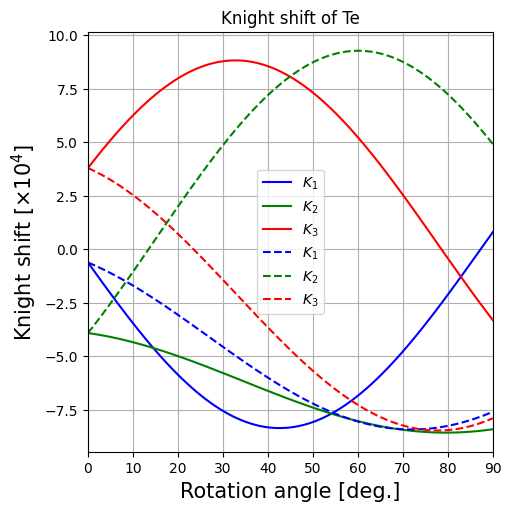

Angle,Shift1[1] value
0,-0.6236656787023706
1,-0.9168853725189701
2,-1.2088830034127802
3,-1.4993028172493437
4,-1.7877909822212446
5,-2.0739960199376584
6,-2.357569233646635
7,-2.6381651330683753
8,-2.9154418553219172
9,-3.1890615814324024
10,-3.458690947911449
11,-3.7240014529092265
12,-3.984669856443343
13,-4.240378574216982
14,-4.490816064546445
15,-4.735677207926702
16,-4.974663678772516
17,-5.207484308882202
18,-5.433855442181239
19,-5.653501280313507
20,-5.866154218659082
21,-6.071555172369271
22,-6.269453892021565
23,-6.4596092685100315
24,-6.641789626799608
25,-6.815773008186451
26,-6.98134744072043
27,-7.138311197460283
28,-7.286473042246838
29,-7.425652462694806
30,-7.5556798901193165
31,-7.676396906129243
32,-7.787656435635609
33,-7.889322926039925
34,-7.98127251238416
35,-8.063393168261094
36,-8.135584842301267
37,-8.197759580070132
38,-8.249841631227001
39,-8.291767541815165
40,-8.323486231570763
41,-8.34495905615622
42,-8.356159854242414
43,-8.35707497938222
44,-8.347703

In [21]:
# In the case of Te. (Te1 is on y-bond).
ks = [-8.572e-4, 1.146e-4, 0.0, 8.830e-4, 0.0, 0.0]

E = np.eye(3)
C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te2.
C3i = C3.T # for Te3.

Rs = [E, C3i, C3]

theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

# 指定フォーマットで出力
output_shift_values(theta, shift1, shift2)

In [22]:

def save_to_csv(filename, angles, shifts, index):
    """
    Save the angles and shifts to a CSV file.

    Args:
        filename (str): Output CSV file name.
        angles (ndarray): Array of angles.
        shifts (list): Shift values for one site.
        index (int): Site index (1-based).
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header
        writer.writerow(["x", "y"])
        # Data
        for angle, shift in zip(angles, shifts):
            writer.writerow([angle, shift])

def output_shift_to_csv(theta, shift1, shift2):
    """
    Output angle and shift values to CSV files.

    Args:
        theta (ndarray): Array of angles.
        shift1 (list): Shift values for each site around n axis.
        shift2 (list): Shift values for each site around nxs axis.
    """
    # Convert angles to degrees
    angles = np.round(theta * 180 / np.pi).astype(int)  # 四捨五入で整数化
    
    # Save Shift1 data
    for i, shifts in enumerate(shift1, start=1):
        filename = f"sample({i}).csv"
        save_to_csv(filename, angles, shifts * 10000, i)
    
    # Save Shift2 data
    for i, shifts in enumerate(shift2, start=1):
        filename = f"sample{i}.csv"
        save_to_csv(filename, angles, shifts * 10000, i)

# 実行例
output_shift_to_csv(theta, shift1, shift2)

In [23]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic((cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]))), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [24]:
# 各CSVファイルの読み込み
csv_files1 = ['sample(1).csv', 'sample(2).csv', 'sample(3).csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['sample1.csv', 'sample2.csv', 'sample3.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [25]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [26]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [27]:
# [0,1,2] の順列を計算
permutations = list(itertools.permutations([0, 1, 2]))

# 6通りの組み合わせを生成
filtered_combinations = [(perm, perm) for perm in permutations]

# 最適化のためのobjective関数
def objective(trial, perm):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', 0.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', -180.0, 180.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 180.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 120.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm in permutations:
    print(f"Evaluating combination: perm1={perm}, perm2={perm}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm}, perm2={perm}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
        k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)  # Fixed to 0
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

        optimizer = optim.Adam([k1, k2, k3, k4, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [k4]:
                    param.data = torch.clamp(param.data, 0.0, 10.0)
                for param in [t1, t2]:
                    param.data = torch.clamp(param.data, 0.0, 180.0)
                for param in [p1]:
                    param.data = torch.clamp(param.data, -180.0, 180.0)
                for param in [p2]:
                    param.data = torch.clamp(param.data, 0.0, 120.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm, perm)

        print(f"Finished training for combination: perm1={perm}, perm2={perm}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-11-25 16:25:53,225] A new study created in memory with name: no-name-7ba7a6e3-154d-439c-8750-1539f0829038
[I 2024-11-25 16:25:53,292] Trial 0 finished with value: 219.02655029296875 and parameters: {'k1': -9.171555591884244, 'k2': -6.689129199144879, 'k3': -0.15124621066454402, 'k4': 7.785125327985723, 't1': 72.91276645043997, 'p1': 29.862137073203087, 't2': 149.4639627207122, 'p2': 78.2091057115255}. Best is trial 0 with value: 219.02655029296875.


Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-11-25 16:25:53,343] Trial 1 finished with value: 281.869384765625 and parameters: {'k1': -8.442477252126235, 'k2': 3.430806994425506, 'k3': -5.090812099062987, 'k4': 1.8007130418768824, 't1': 65.04322934837356, 'p1': -165.82543812721502, 't2': 50.498192417384516, 'p2': 35.354183889145226}. Best is trial 0 with value: 219.02655029296875.
[I 2024-11-25 16:25:53,395] Trial 2 finished with value: 737.2528686523438 and parameters: {'k1': 8.720414995545426, 'k2': 9.962992239637977, 'k3': 5.195177569852991, 'k4': 0.17252698465064165, 't1': 98.8783296295532, 'p1': 100.90266896171227, 't2': 0.7620670942326857, 'p2': 60.9754516638333}. Best is trial 0 with value: 219.02655029296875.
[I 2024-11-25 16:25:53,443] Trial 3 finished with value: 533.2261352539062 and parameters: {'k1': -8.512296840710835, 'k2': 8.04974457023867, 'k3': -8.97311976719709, 'k4': 7.401887455261279, 't1': 136.06651718612522, 'p1': 110.59814835739706, 't2': 156.2516477806118, 'p2': 96.3432117751049}. Best is trial 0 

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 27.849899291992188
Parameters: k1=-7.7382917404174805, k2=0.5734425187110901, k3=0.5483530759811401, k4=8.694515228271484, k5=0.0, k6=0.0, t1=95.38079071044922, p1=-40.44163513183594, t2=167.7879638671875, p2=69.10511016845703
Epoch 100, Loss: 14.073519706726074
Parameters: k1=-9.658949851989746, k2=2.963367223739624, k3=0.36547401547431946, k4=7.854556083679199, k5=0.0, k6=0.0, t1=96.57781219482422, p1=-34.78144454956055, t2=166.4541473388672, p2=59.46727752685547
Epoch 200, Loss: 9.146504402160645
Parameters: k1=-9.805198669433594, k2=2.891864538192749, k3=0.4324086904525757, k4=7.916306018829346, k5=0.0, k6=0.0, t1=99.96965026855469, p1=-29.004135131835938, t2=163.67176818847656, p2=50.256465911865234
Epoch 300, Loss: 6.432506561279297
Parameters: k1=-9.663909912109375, k2=2.59256911277771, k3=0.3536626100540161, k4=8.076814651489258, k5=0.0, k6=0.0, t1=98.76464080810547, p1=-26.901473999023438, t2=16

[I 2024-11-25 16:30:11,483] A new study created in memory with name: no-name-fcf7055e-c217-4095-a54c-5c475aa2f29a
[I 2024-11-25 16:30:11,538] Trial 0 finished with value: 632.7888793945312 and parameters: {'k1': 1.8615204246465709, 'k2': 3.344290323393494, 'k3': -0.1665025187170226, 'k4': 9.299657748259987, 't1': 129.04279419146258, 'p1': 145.36322382350744, 't2': 120.22217083549435, 'p2': 40.99756281003867}. Best is trial 0 with value: 632.7888793945312.
[I 2024-11-25 16:30:11,587] Trial 1 finished with value: 416.469970703125 and parameters: {'k1': -6.42272124402642, 'k2': 5.00372329270008, 'k3': 9.442623043096315, 'k4': 0.009434014072400299, 't1': 80.66111667278874, 'p1': -88.76122017986762, 't2': 148.20233055807358, 'p2': 19.43951303340205}. Best is trial 1 with value: 416.469970703125.
[I 2024-11-25 16:30:11,637] Trial 2 finished with value: 333.1748352050781 and parameters: {'k1': 1.0788332816665154, 'k2': 0.9042774546465733, 'k3': 6.291899401235355, 'k4': 2.2104803727381395, 't1

Loss increased at epoch 2253. Stopping training.
Best params during epoch training: {'k1': -8.571817398071289, 'k2': 1.1460309028625488, 'k3': -4.418568278197199e-05, 'k4': 8.829806327819824, 'k5': 0.0, 'k6': 0.0, 't1': 77.18102264404297, 'p1': -31.81038475036621, 't2': 164.89637756347656, 'p2': 0.553556501865387}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-11-25 16:30:11,687] Trial 3 finished with value: 389.3215637207031 and parameters: {'k1': 0.9904913840398759, 'k2': 4.436257346662815, 'k3': 0.6726299853494453, 'k4': 8.37991060713195, 't1': 92.0647980393956, 'p1': 9.865942078220911, 't2': 63.806442260895786, 'p2': 54.44748839242483}. Best is trial 2 with value: 333.1748352050781.
[I 2024-11-25 16:30:11,741] Trial 4 finished with value: 345.9871826171875 and parameters: {'k1': -2.1281768794062543, 'k2': -4.616890768109556, 'k3': -4.426445486708768, 'k4': 6.314511648724145, 't1': 108.71001672632333, 'p1': 164.21552506592468, 't2': 3.4172292236215673, 'p2': 57.53583008914078}. Best is trial 2 with value: 333.1748352050781.
[I 2024-11-25 16:30:11,790] Trial 5 finished with value: 572.6710815429688 and parameters: {'k1': -8.739210700404849, 'k2': 9.195805369286685, 'k3': 4.8833654533855615, 'k4': 7.59058843208401, 't1': 70.86664937866824, 'p1': 55.137489595896085, 't2': 59.243315135125236, 'p2': 5.599467033728174}. Best is trial 2 

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0 Loss is 44.5635986328125, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-11-25 16:30:45,797] Trial 3 finished with value: 310.5203552246094 and parameters: {'k1': -5.60628483811046, 'k2': -4.5383576788716535, 'k3': -3.0312651243747357, 'k4': 9.922053979879333, 't1': 51.27385804833787, 'p1': 143.19359494223238, 't2': 155.69096258193989, 'p2': 5.86252090980298}. Best is trial 3 with value: 310.5203552246094.
[I 2024-11-25 16:30:45,847] Trial 4 finished with value: 431.2926025390625 and parameters: {'k1': 7.226154022529158, 'k2': -7.616400160861878, 'k3': 8.90024399207472, 'k4': 3.441097790228751, 't1': 99.25017022117922, 'p1': -112.34711634067557, 't2': 17.655259501582755, 'p2': 116.010548427103}. Best is trial 3 with value: 310.5203552246094.
[I 2024-11-25 16:30:45,896] Trial 5 finished with value: 314.9792175292969 and parameters: {'k1': 0.8358316775475032, 'k2': -5.910723838014693, 'k3': 8.011416886919303, 'k4': 8.641406011887042, 't1': 43.3867491801437, 'p1': 161.62879706746338, 't2': 77.77902081568622, 'p2': 4.170313333550699}. Best is trial 3 wi

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0 Loss is 48.98995590209961, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-11-25 16:31:20,093] Trial 3 finished with value: 447.7300109863281 and parameters: {'k1': 8.366768184874772, 'k2': -6.34648177662775, 'k3': -0.9189262569870493, 'k4': 5.58687377703345, 't1': 56.83919989383406, 'p1': 133.41893027624218, 't2': 109.81977870893263, 'p2': 54.04028879063293}. Best is trial 2 with value: 279.23822021484375.
[I 2024-11-25 16:31:20,144] Trial 4 finished with value: 338.4161376953125 and parameters: {'k1': 7.012349231863393, 'k2': -4.909986393369376, 'k3': 8.211939770924374, 'k4': 2.5020065148230364, 't1': 25.604960675606698, 'p1': -61.66464624824981, 't2': 27.402369506568203, 'p2': 117.35008294102256}. Best is trial 2 with value: 279.23822021484375.
[I 2024-11-25 16:31:20,193] Trial 5 finished with value: 390.6093444824219 and parameters: {'k1': -6.092493534980639, 'k2': -0.9778370219196617, 'k3': -8.331327164350151, 'k4': 6.479536861691196, 't1': 9.618626726521999, 'p1': 175.9243800571482, 't2': 172.32560597879336, 'p2': 71.25689830771738}. Best is tri

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0 Loss is 50.112918853759766, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-11-25 16:31:55,059] Trial 1 finished with value: 534.60107421875 and parameters: {'k1': 5.093435691875234, 'k2': -7.3009910629678565, 'k3': 7.971088075781569, 'k4': 5.813203052683475, 't1': 98.47423832891802, 'p1': -32.201964861221114, 't2': 149.38605227300567, 'p2': 8.587735082411054}. Best is trial 0 with value: 405.552490234375.
[I 2024-11-25 16:31:55,119] Trial 2 finished with value: 262.8805847167969 and parameters: {'k1': 1.7498121714713388, 'k2': -2.9817449229035997, 'k3': -1.3357981155197685, 'k4': 5.718990137958212, 't1': 71.68612216435199, 'p1': 35.83315582400397, 't2': 120.36656205587082, 'p2': 46.954650410372466}. Best is trial 2 with value: 262.8805847167969.
[I 2024-11-25 16:31:55,172] Trial 3 finished with value: 436.0497131347656 and parameters: {'k1': 4.478991004417933, 'k2': -7.002642311492857, 'k3': 1.601836004587934, 'k4': 9.926950042368748, 't1': 145.95618786821865, 'p1': 66.44086780213004, 't2': 146.28141490440856, 'p2': 11.715067718988426}. Best is trial 

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 20.266021728515625
Parameters: k1=-9.11285400390625, k2=4.125441074371338, k3=-0.8397703766822815, k4=6.4118547439575195, k5=0.0, k6=0.0, t1=57.69792556762695, p1=84.90667724609375, t2=162.3885498046875, p2=91.27877807617188
Epoch 100, Loss: 3.2694640159606934
Parameters: k1=-9.914692878723145, k2=1.8604981899261475, k3=-0.14098139107227325, k4=8.757604598999023, k5=0.0, k6=0.0, t1=63.23805236816406, p1=87.3805160522461, t2=165.8260498046875, p2=100.54263305664062
Epoch 200, Loss: 1.2176003456115723
Parameters: k1=-9.251907348632812, k2=1.436890959739685, k3=-0.0938987210392952, k4=8.881945610046387, k5=0.0, k6=0.0, t1=65.52989959716797, p1=86.69048309326172, t2=165.08270263671875, p2=107.93506622314453
Epoch 300, Loss: 0.37672486901283264
Parameters: k1=-8.956881523132324, k2=1.2902154922485352, k3=-0.05707809701561928, k4=8.917086601257324, k5=0.0, k6=0.0, t1=67.74720764160156, p1=86.45902252197266, t2

[I 2024-11-25 16:34:46,521] A new study created in memory with name: no-name-299d1afc-c037-4dd0-af09-a69106131511
[I 2024-11-25 16:34:46,578] Trial 0 finished with value: 239.57485961914062 and parameters: {'k1': -0.9218891982807094, 'k2': -2.665102278379754, 'k3': -6.376204493528501, 'k4': 0.5810677541847853, 't1': 46.253355325889345, 'p1': 158.66584122922683, 't2': 69.13956241158868, 'p2': 38.69172373568278}. Best is trial 0 with value: 239.57485961914062.
[I 2024-11-25 16:34:46,630] Trial 1 finished with value: 479.8955078125 and parameters: {'k1': -0.05888732142202002, 'k2': -8.815923431419115, 'k3': 9.054379912107741, 'k4': 6.847563379056587, 't1': 10.751239783337255, 'p1': -88.78366625370722, 't2': 90.87979583182303, 'p2': 63.81223283907805}. Best is trial 0 with value: 239.57485961914062.
[I 2024-11-25 16:34:46,681] Trial 2 finished with value: 239.14678955078125 and parameters: {'k1': -5.010638833631232, 'k2': -8.634119021970063, 'k3': 1.0106675390573638, 'k4': 3.66686258405750

Loss increased at epoch 1373. Stopping training.
Best params during epoch training: {'k1': -8.578400611877441, 'k2': 1.1433755159378052, 'k3': -0.0031375910621136427, 'k4': 8.837645530700684, 'k5': 0.0, 'k6': 0.0, 't1': 76.40740203857422, 'p1': 87.93074035644531, 't2': 164.91090393066406, 'p2': 120.0}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-11-25 16:34:46,732] Trial 3 finished with value: 381.26617431640625 and parameters: {'k1': 7.694078027665718, 'k2': -5.027391352140276, 'k3': 1.993584930959468, 'k4': 2.4386614395516526, 't1': 77.01730549717627, 'p1': -150.32589529291508, 't2': 56.40686867401778, 'p2': 94.6891150434566}. Best is trial 2 with value: 239.14678955078125.
[I 2024-11-25 16:34:46,786] Trial 4 finished with value: 223.23756408691406 and parameters: {'k1': -9.941506285774693, 'k2': 0.6014405327990744, 'k3': 0.20997185576669253, 'k4': 0.5256150759193468, 't1': 149.66294894653907, 'p1': -23.836510268946682, 't2': 40.68201773843401, 'p2': 60.41077867933446}. Best is trial 4 with value: 223.23756408691406.
[I 2024-11-25 16:34:46,838] Trial 5 finished with value: 452.8119201660156 and parameters: {'k1': 6.12341691013123, 'k2': 4.847088128036756, 'k3': 0.4148870106143967, 'k4': 7.075574463548185, 't1': 114.46603258936034, 'p1': 65.68114825262842, 't2': 58.391001204801455, 'p2': 97.48447837933648}. Best is tr

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 14.690923690795898
Parameters: k1=-6.074325084686279, k2=5.2945098876953125, k3=-4.121176242828369, k4=7.339064121246338, k5=0.0, k6=0.0, t1=57.784934997558594, p1=27.667390823364258, t2=98.76261138916016, p2=86.8498306274414
Epoch 100, Loss: 3.3402554988861084
Parameters: k1=-6.889498710632324, k2=6.146836757659912, k3=-5.7430338859558105, k4=8.25904655456543, k5=0.0, k6=0.0, t1=52.116947174072266, p1=20.50569725036621, t2=94.11625671386719, p2=85.606201171875
Epoch 200, Loss: 2.768315315246582
Parameters: k1=-6.8569207191467285, k2=6.113592624664307, k3=-5.774670124053955, k4=8.090835571289062, k5=0.0, k6=0.0, t1=53.14220428466797, p1=15.652538299560547, t2=94.73773193359375, p2=84.67137908935547
Epoch 300, Loss: 2.4860262870788574
Parameters: k1=-6.832644939422607, k2=6.086918830871582, k3=-5.824973106384277, k4=7.983337879180908, k5=0.0, k6=0.0, t1=53.93928909301758, p1=11.810076713562012, t2=95.2156

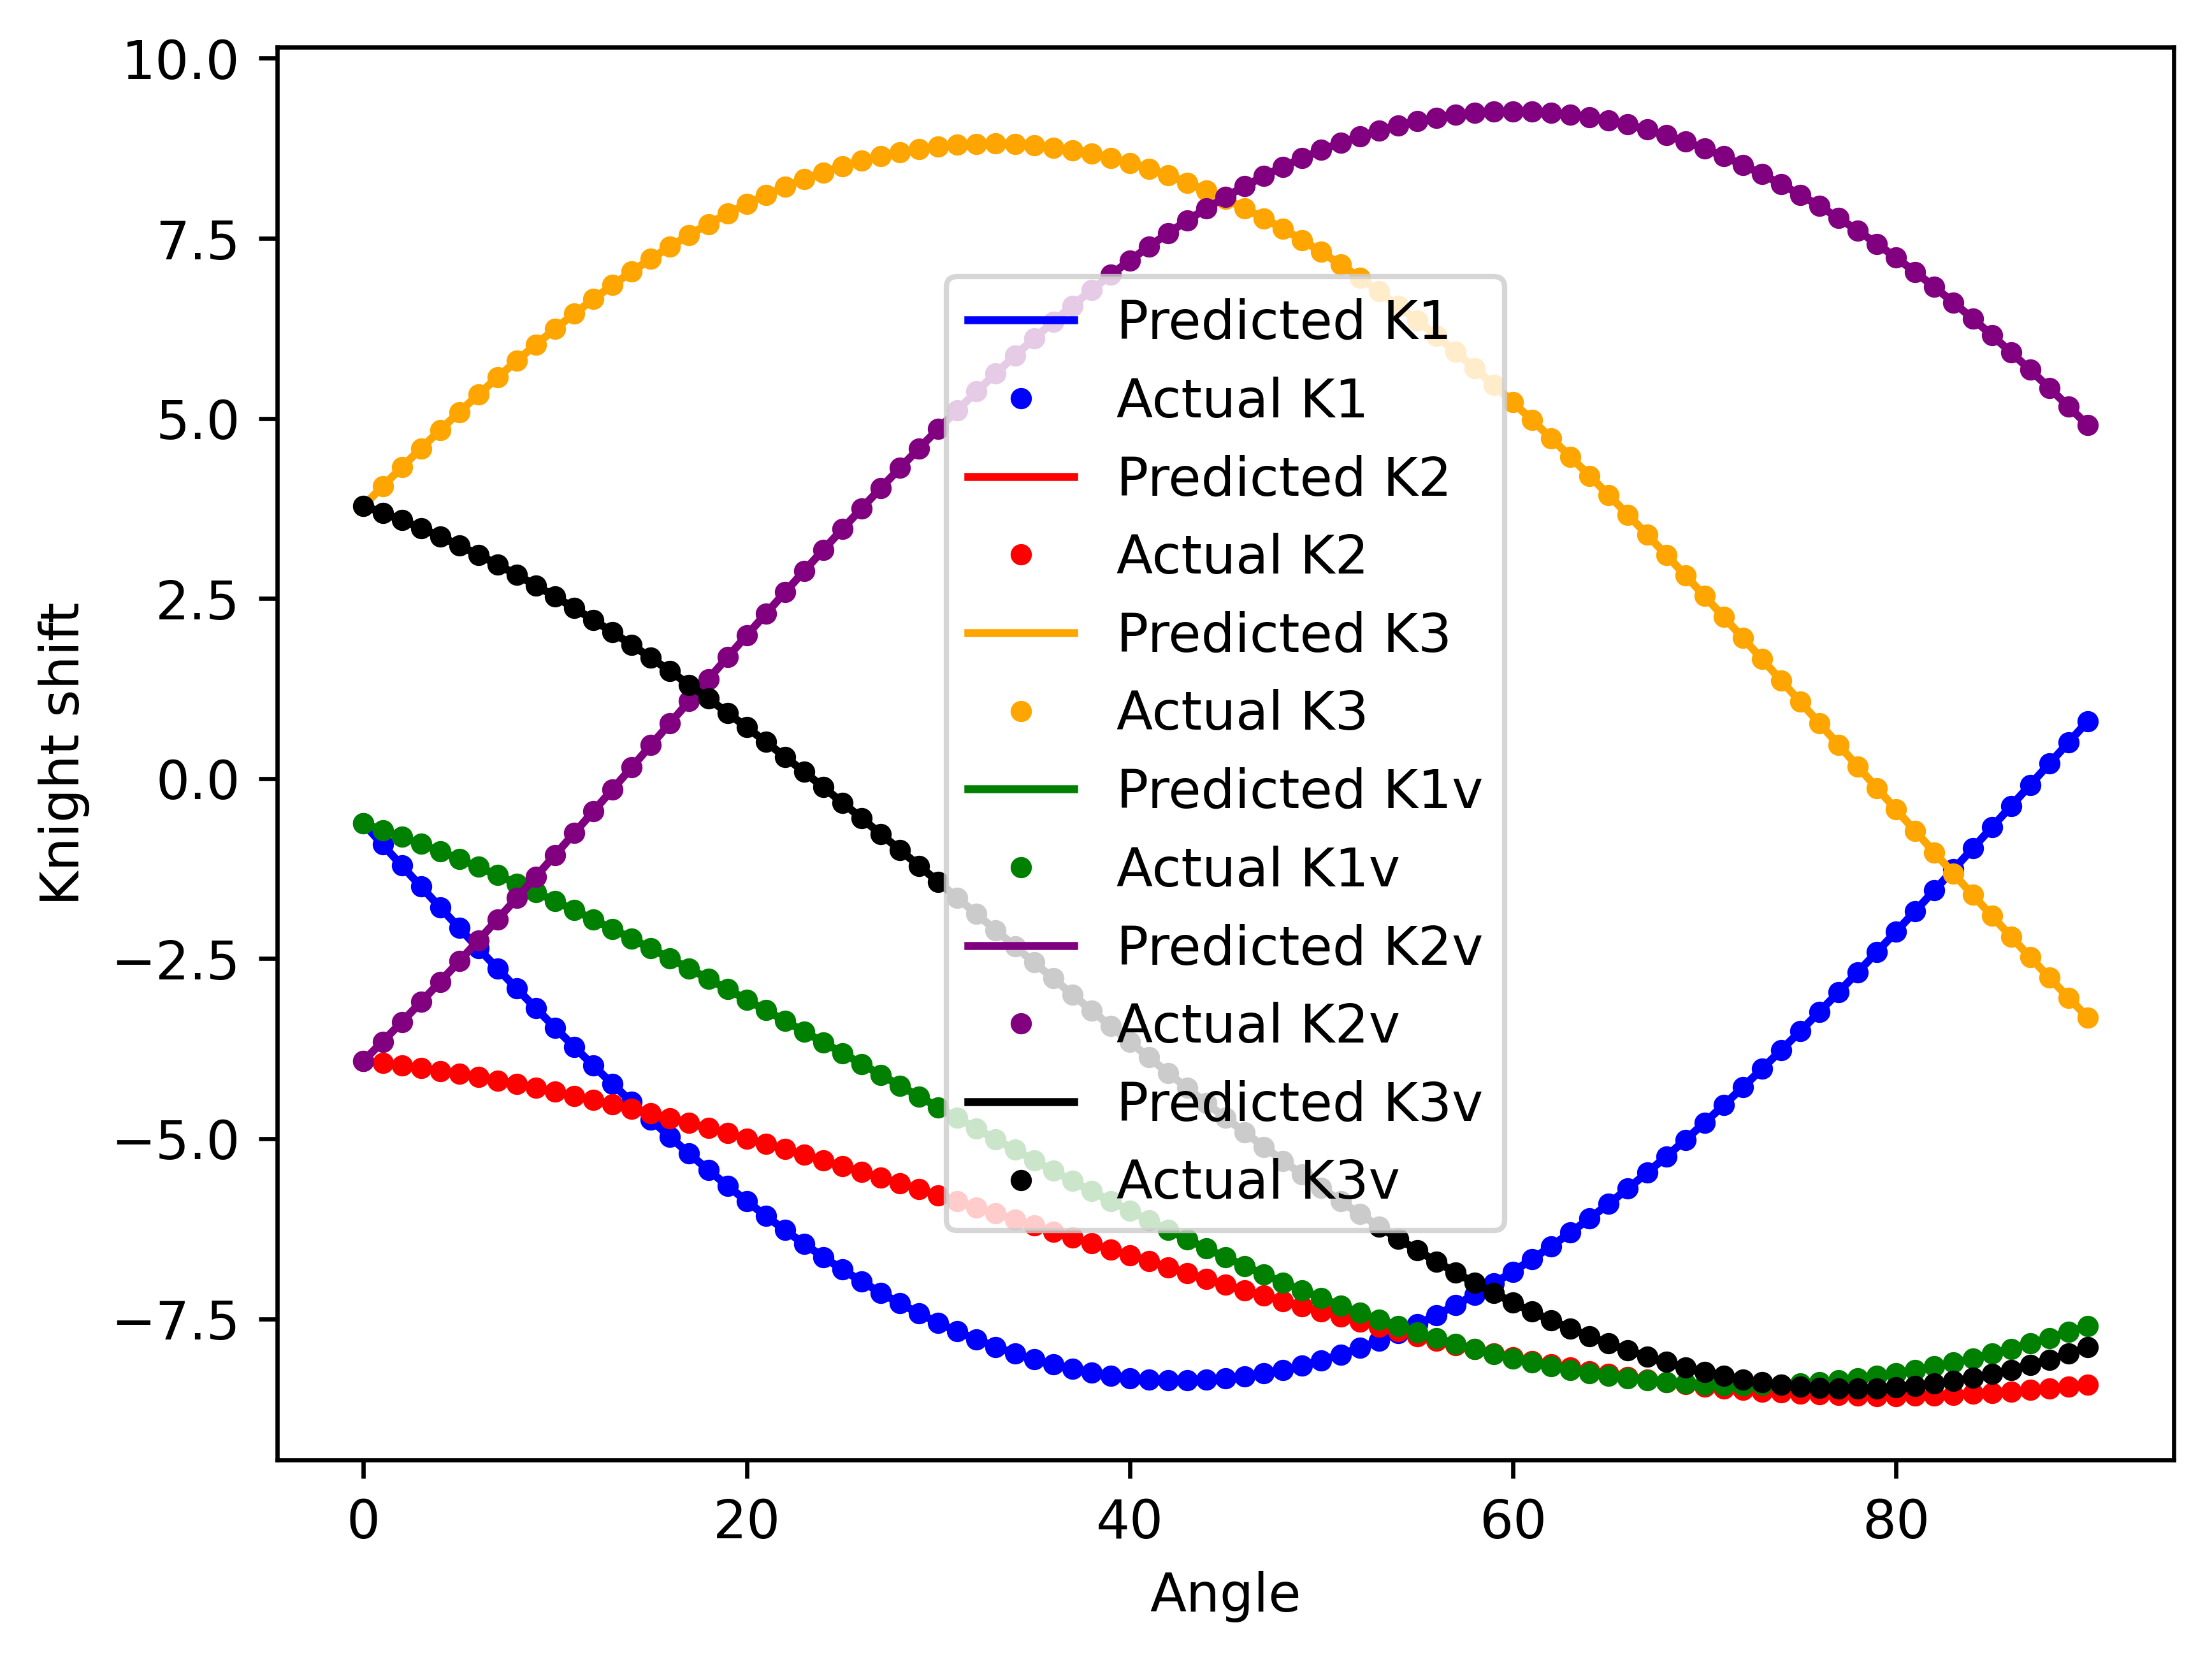

{'k1': -8.571817398071289, 'k2': 1.1460309028625488, 'k3': -4.418568278197199e-05, 'k4': 8.829806327819824, 'k5': 0.0, 'k6': 0.0, 't1': 77.18102264404297, 'p1': -31.81038475036621, 't2': 164.89637756347656, 'p2': 0.553556501865387}


In [28]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), '.', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), '.', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), '.', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), '.', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), '.', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), '.', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)